In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
from sqlite3 import connect

In [117]:
df_athletes = pd.read_csv('athlete_events.csv')
df_regions = pd.read_csv('noc_regions.csv')
df_athletes.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [118]:
df_regions.head(5)

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


In [119]:
df_athletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [120]:
df_regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-null    object
 1   region  227 non-null    object
 2   notes   21 non-null     object
dtypes: object(3)
memory usage: 5.5+ KB


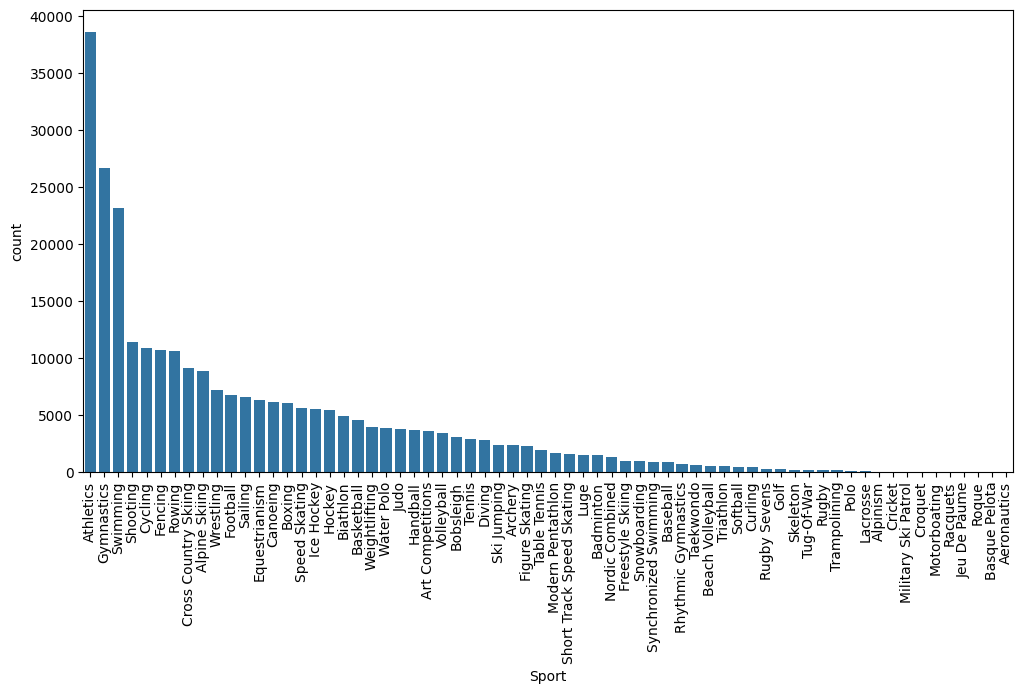

In [121]:
# Plot the distributon of sports
plt.figure(figsize=(12, 6))
sns.countplot(x='Sport', data=df_athletes, order=df_athletes['Sport'].value_counts().index)
plt.xticks(rotation=90)
plt.show()


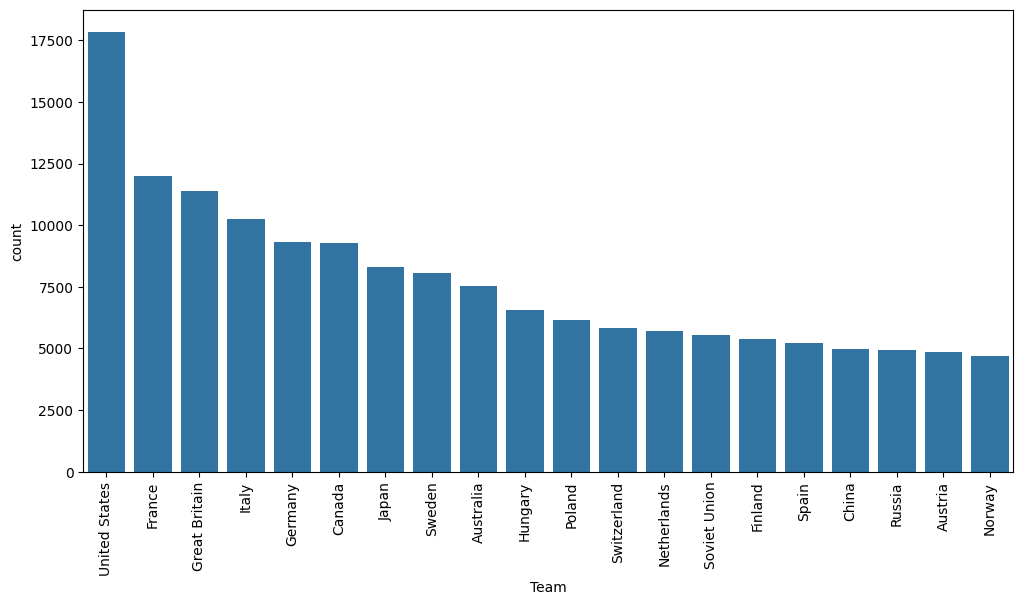

In [122]:
# Plot the distribution of teams
plt.figure(figsize=(12, 6))
top20_teams = df_athletes['Team'].value_counts().head(20)
sns.countplot(x='Team', data=df_athletes, order=top20_teams.index)
plt.xticks(rotation=90)
plt.show()

Let's drop some columns and generate SQL tables, and add an 'Event_ID' column to them to work as a PK on the Event Table and as FK in the Athletes Table. (However, since the table is small, we will not need to make any join or especial manipulation.)

In [123]:
Athletes = df_athletes.drop(['Team','Games'], axis=1,inplace=False)
Athletes.insert(loc=1, column="Event_ID", value=range(1, 1 + len(Athletes)), allow_duplicates=False)
Event = df_athletes.drop(['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'Team', 'NOC', 'Games', 'Medal'], axis=1,inplace=False)
Event.insert(loc=1, column="Event_ID", value=range(1, 1 + len(Event)), allow_duplicates=False)

In [124]:
# With this python library we need to create a connector to keep the SQL Tables
engine = connect(':memory:')

In [125]:
Athletes.to_sql('AthletesTable', con=engine)
Event.to_sql('EventTable', con=engine)

271116

Male / Female ratio found with sql and then plot with pie plot

In [126]:
df_sex_ratio = pd.read_sql(
    '''
    SELECT 
        sex,
        COUNT(*) AS total
    FROM
        AthletesTable
    GROUP BY
        sex
    ''', con=engine
)
df_sex_ratio

,Sex,total
0,F,74522
1,M,196594


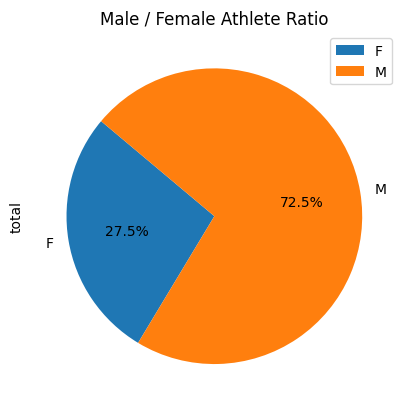

In [127]:
df_sex_ratio.plot.pie(y='total', labels=df_sex_ratio['Sex'],
                       autopct='%1.1f%%', startangle=140)
plt.title('Male / Female Athlete Ratio')
plt.show()

In [128]:
# Using plotly express to plot distribution of medals in winter games by all world map
df_medals = df_athletes[df_athletes['Season'] == 'Winter'] 
df_medals_count = df_medals.groupby('NOC').size().reset_index(name='Medal_Count')
df_medals = pd.merge(df_medals_count, df_regions, on='NOC', how='left')


fig = px.choropleth(df_medals,
                    locations='NOC', 
                    locationmode='ISO-3', 
                    color='Medal_Count',  # Replace 'Medal_Count' with the actual column name
                    color_continuous_scale='Oranges', 
                    scope='world', 
                    title='Number of Medals by Country in Winter Games')
fig.show()


In [129]:
# Using plotly express to plot distribution of medals in summer games by all world map
df_medals = df_athletes[df_athletes['Season'] == 'Summer'] 
df_medals_count = df_medals.groupby('NOC').size().reset_index(name='Medal_Count')
df_medals = pd.merge(df_medals_count, df_regions, on='NOC', how='left')


fig = px.choropleth(df_medals,
                    locations='NOC', 
                    locationmode='ISO-3', 
                    color='Medal_Count',  # Replace 'Medal_Count' with the actual column name
                    color_continuous_scale='Oranges', 
                    scope='world', 
                    title='Number of Medals by Country in Summer Games')
fig.show()


In [130]:
# The reperesentation of male and female during the years
df_gender_distribution = pd.read_sql(
    '''
         SELECT
            SUM(CASE WHEN sex='M' THEN 1 ELSE 0 END)    AS male_count,
            SUM(CASE WHEN sex='F' THEN 1 ELSE 0 END)    AS female_count,
            Year
        FROM
            AthletesTable
        GROUP BY
            Year 
        ORDER BY 
            Year                  
    ''', con=engine)

# Long-form DataFrame is expected for Plotly Express, so we melt the DataFrame to long form
df_long = df_gender_distribution.melt(id_vars='Year', value_vars=['female_count', 'male_count'], var_name='Gender', value_name='Count')

# Now, we can plot using Plotly Express
fig = px.line(df_long, x='Year', y='Count', color='Gender', line_group='Gender', markers=True, 
              color_discrete_map={'female_count': 'red', 'male_count': 'blue'})

fig.show()


In [131]:
# Counting number of medals by country
df_medals = pd.read_sql(
    '''
    SELECT
        NOC,
        COUNT(*) AS medals_count
    FROM
        AthletesTable
    WHERE
        Medal IS NOT NULL
    GROUP BY
        NOC
    ORDER BY
        medals_count DESC
    LIMIT 10
    ''', con=engine
)
df_medals

,NOC,medals_count
0,USA,5637
1,URS,2503
2,GER,2165
3,GBR,2068
4,FRA,1777
5,ITA,1637
6,SWE,1536
7,CAN,1352
8,AUS,1320
9,RUS,1165


<Axes: xlabel='Age_Group'>

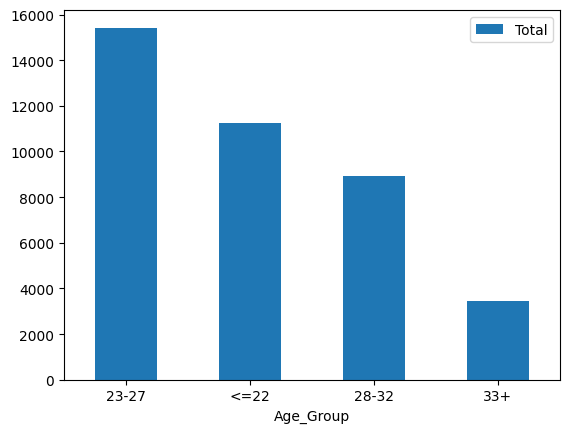

In [132]:
avg_years = pd.read_sql(
    '''
    SELECT
        case
          when Age between 0 and 22 then '<=22'
          when Age between 23 and 27 then '23-27'
          when Age between 28 and 33 then '28-32'
          else '33+'
        end as Age_Group,
        Count(*) as Total
    FROM
        AthletesTable
    WHERE
        Age IS NOT NULL AND Medal IS NOT NULL

    GROUP BY
        Age_Group
    ORDER BY
        Total DESC
 
    ''', con=engine)
avg_years.plot.bar(x='Age_Group', y='Total', rot=0)


In [133]:
Athletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ID        271116 non-null  int64  
 1   Event_ID  271116 non-null  int64  
 2   Name      271116 non-null  object 
 3   Sex       271116 non-null  object 
 4   Age       261642 non-null  float64
 5   Height    210945 non-null  float64
 6   Weight    208241 non-null  float64
 7   NOC       271116 non-null  object 
 8   Year      271116 non-null  int64  
 9   Season    271116 non-null  object 
 10  City      271116 non-null  object 
 11  Sport     271116 non-null  object 
 12  Event     271116 non-null  object 
 13  Medal     39783 non-null   object 
dtypes: float64(3), int64(3), object(8)
memory usage: 29.0+ MB


In [134]:
df_athletes['Sport'].value_counts()

Sport
Athletics        38624
Gymnastics       26707
Swimming         23195
Shooting         11448
Cycling          10859
                 ...  
Racquets            12
Jeu De Paume        11
Roque                4
Basque Pelota        2
Aeronautics          1
Name: count, Length: 66, dtype: int64

In [135]:
# Define a function for each column to apply the encoding
def encode_sex(x):
    return 1 if x == 'M' else 0

def encode_season(x):
    return 1 if x == 'Summer' else 0

def encode_medal(x):
    if x == 'Gold':
        return 1
    elif x == 'Silver':
        return 2
    else:
        return 3 

# Apply the encoding functions to the respective columns
df_athletes['Sex'] = df_athletes['Sex'].apply(encode_sex)
df_athletes['Season'] = df_athletes['Season'].apply(encode_season)
df_athletes['Medal'] = df_athletes['Medal'].apply(encode_medal)


        
df_athletes.head(5) 

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,1,24.0,180.0,80.0,China,CHN,1992 Summer,1992,1,Barcelona,Basketball,Basketball Men's Basketball,3
1,2,A Lamusi,1,23.0,170.0,60.0,China,CHN,2012 Summer,2012,1,London,Judo,Judo Men's Extra-Lightweight,3
2,3,Gunnar Nielsen Aaby,1,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,1,Antwerpen,Football,Football Men's Football,3
3,4,Edgar Lindenau Aabye,1,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,1,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,1
4,5,Christine Jacoba Aaftink,0,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,0,Calgary,Speed Skating,Speed Skating Women's 500 metres,3


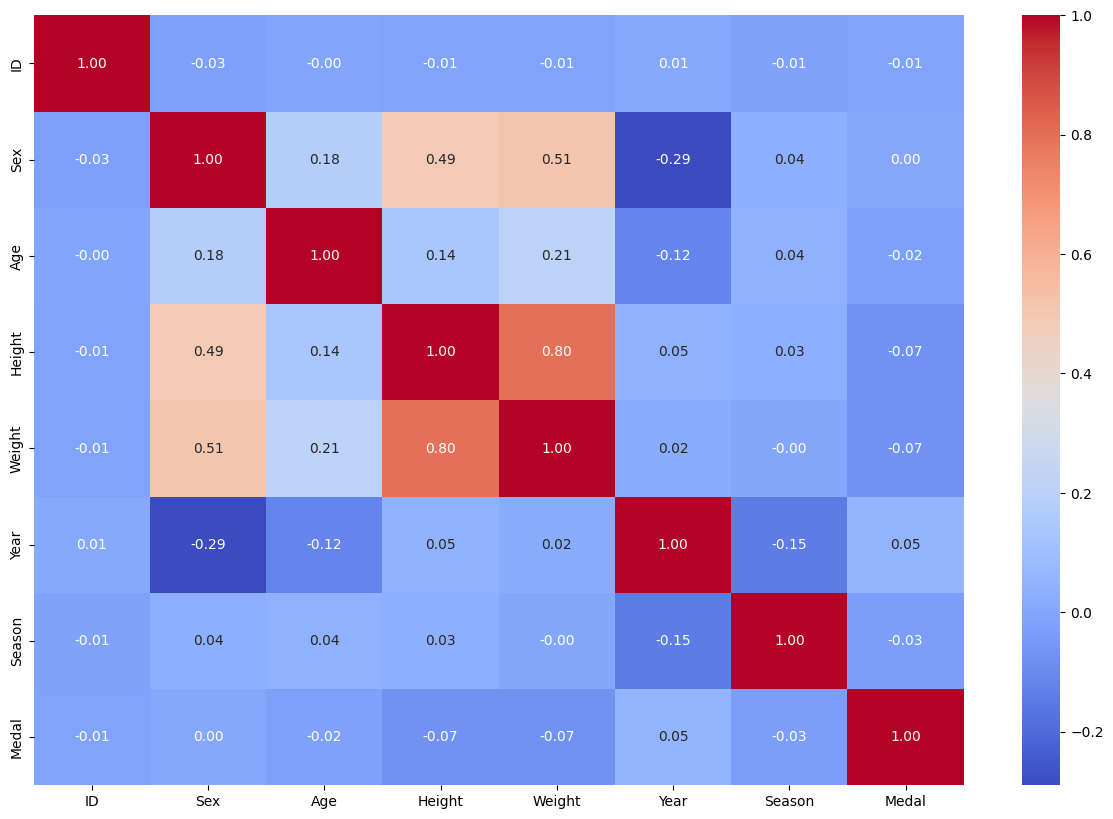

In [136]:
# Pearson Correlation

plt.figure(figsize=(15,10))
sns.heatmap(df_athletes.corr(method='pearson', numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()


In [137]:
# Creating BMI in Athletes Table
BMI = pd.read_sql('''
SELECT
    Year,
    Age,
    Sex,
    Weight,
    Height,
    Season,
    Sport,
    (Weight)/(Height/100 * Height/100) AS BMI
FROM
    AthletesTable
WHERE
     (Height IS NOT NULL) AND (Weight IS NOT NULL)
GROUP BY
    Sport
ORDER BY
    BMI DESC
''', con=engine)

BMI

,Year,Age,Sex,Weight,Height,Season,Sport,BMI
0,2016,22.0,F,125.0,170.0,Summer,Weightlifting,43.252595
1,2000,31.0,M,130.0,189.0,Summer,Athletics,36.393158
2,2006,24.0,M,95.0,175.0,Winter,Curling,31.020408
3,1924,21.0,M,98.0,178.0,Summer,Rugby,30.930438
4,2000,21.0,M,91.0,179.0,Summer,Baseball,28.401111
5,2002,26.0,M,96.0,186.0,Winter,Ice Hockey,27.748873
6,1992,27.0,M,82.0,172.0,Summer,Canoeing,27.717685
7,1992,20.0,M,85.0,176.0,Winter,Alpine Skiing,27.440599
8,1932,44.0,M,91.0,183.0,Summer,Art Competitions,27.173102
9,1998,24.0,M,98.0,190.0,Winter,Bobsleigh,27.146814


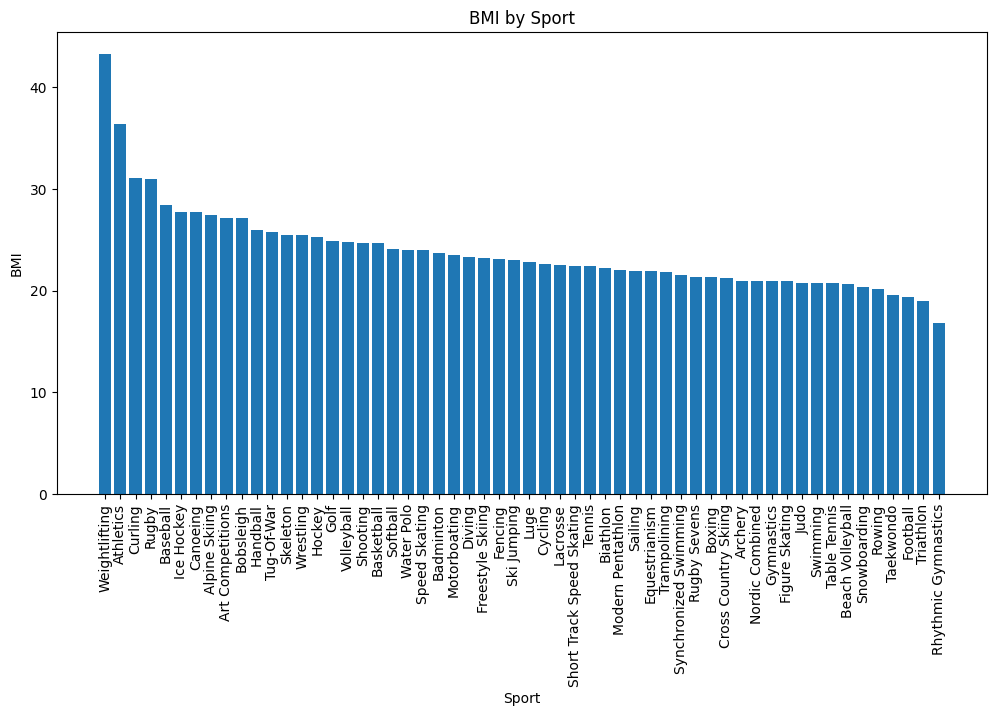

In [138]:
# Plotting BMI by Sport
plt.figure(figsize=(12, 6))
plt.bar(BMI['Sport'], BMI['BMI'])
plt.xticks(rotation=90)
plt.xlabel('Sport')
plt.ylabel('BMI')
plt.title('BMI by Sport')
plt.show()

In [139]:
# Updating the Athletes Table with the BMI and medal

In [140]:
medal_ratio = pd.read_sql(
    '''
    SELECT
        year,
        season,
        CAST(total_medals AS FLOAT) / total_count AS medal_ratio,
        CAST(gold_count AS FLOAT)/total_medals AS gold_ratio,
        CAST(silver_count AS FLOAT)/total_medals AS silver_ratio,
        CAST(bronze_count AS FLOAT)/total_medals AS bronze_ratio
    FROM
        (SELECT
            year,
            season,
            COUNT(*) AS total_count,
            SUM(CASE WHEN Medal IS NOT NULL THEN 1 ELSE 0 END) AS total_medals,
            SUM(CASE WHEN Medal = 'Gold'    THEN 1 ELSE 0 END) AS gold_count,
            SUM(CASE WHEN Medal = 'Silver'  THEN 1 ELSE 0 END) AS silver_count,
            SUM(CASE WHEN Medal = 'Bronze'  THEN 1 ELSE 0 END) AS bronze_count
        FROM
            AthletesTable
        WHERE
            medal IS NOT NULL   
        GROUP BY
            year,season
        ORDER BY
            year) AS medals
    ''', con=engine)

medal_ratio

,year,season,medal_ratio,gold_ratio,silver_ratio,bronze_ratio
0,1896,Summer,1.0,0.433566,0.300699,0.265734
1,1900,Summer,1.0,0.332781,0.377483,0.289735
2,1904,Summer,1.0,0.355967,0.335391,0.308642
3,1906,Summer,1.0,0.342795,0.340611,0.316594
4,1908,Summer,1.0,0.353791,0.338147,0.308063
5,1912,Summer,1.0,0.346440,0.334750,0.318810
6,1920,Summer,1.0,0.376911,0.342508,0.280581
7,1924,Summer,1.0,0.332933,0.337740,0.329327
8,1924,Winter,1.0,0.423077,0.292308,0.284615
9,1928,Summer,1.0,0.333787,0.325613,0.340599


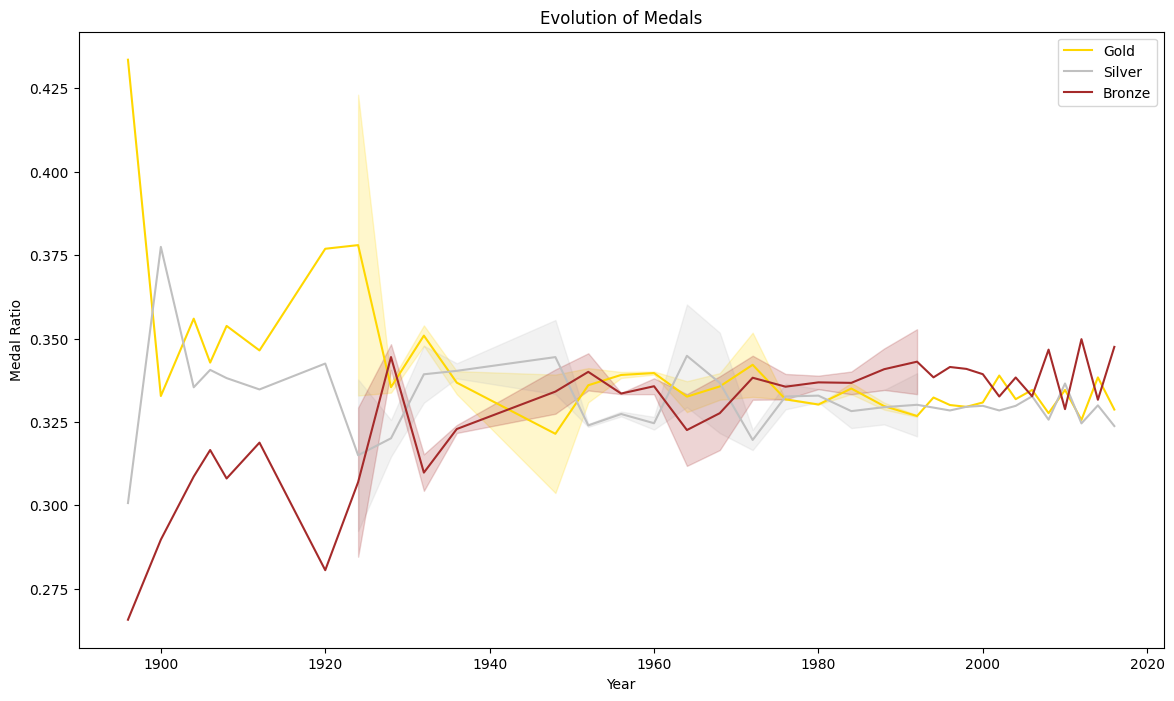

In [141]:
plt.figure(figsize=[14,8])
sns.lineplot(data=medal_ratio, x='year', y = 'gold_ratio',   color='gold', label='Gold')
sns.lineplot(data=medal_ratio, x='year', y = 'silver_ratio', color='silver', label='Silver')
sns.lineplot(data=medal_ratio, x='year', y = 'bronze_ratio', color='brown', label='Bronze')
plt.xlabel('Year')
plt.ylabel('Medal Ratio')
plt.title('Evolution of Medals')
plt.show()

In [143]:
df_athletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  int64  
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  int64  
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   271116 non-null  int64  
dtypes: float64(3), int64(5), object(7)
memory usage: 31.0+ MB


In [153]:
df_athletes['Medal'].value_counts()

Medal
3    186132
1     10167
2      9866
Name: count, dtype: int64

In [145]:
# Fast Pre-Processing
df_athletes.drop(['Name','Games','ID','Team', 'Event'], axis=1, inplace=True)
df_athletes.dropna(inplace=True)
# Instead Height and Weight, we will use BMI
df_athletes['BMI'] = df_athletes['Weight'] / (df_athletes['Height'] / 100) ** 2
df_athletes.drop(['Height','Weight'], axis=1, inplace=True)
# Encoding the categorical variables
df_athletes = pd.get_dummies(df_athletes, columns=['City', 'Sport','NOC'])
df_athletes.head(5)


,Sex,Age,Year,Season,Medal,BMI,City_Albertville,City_Amsterdam,City_Antwerpen,City_Athina,...,NOC_VIE,NOC_VIN,NOC_VNM,NOC_WIF,NOC_YAR,NOC_YEM,NOC_YMD,NOC_YUG,NOC_ZAM,NOC_ZIM
0,1,24.0,1992,1,3,24.691358,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,23.0,2012,1,3,20.761246,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,21.0,1988,0,3,23.959094,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,0,21.0,1988,0,3,23.959094,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,0,25.0,1992,0,3,23.959094,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [146]:
df_athletes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206165 entries, 0 to 271115
Columns: 330 entries, Sex to NOC_ZIM
dtypes: bool(324), float64(2), int64(4)
memory usage: 74.7 MB


In [154]:
# Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN

X = df_athletes.drop('Medal', axis=1)
y = df_athletes['Medal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fast Class-Balance
smotee = SMOTEENN()
X_train, y_train = smotee.fit_resample(X_train, y_train)

y_train.value_counts()




In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = [1 if i < 1.2 else 2 if i < 2.2 else 3 for i in y_pred]
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))